Epoch 1/100


c:\Users\User\Desktop\tensorflow\tensorflow\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0633 - val_loss: 0.0032
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0049
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0074
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0055
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_lo

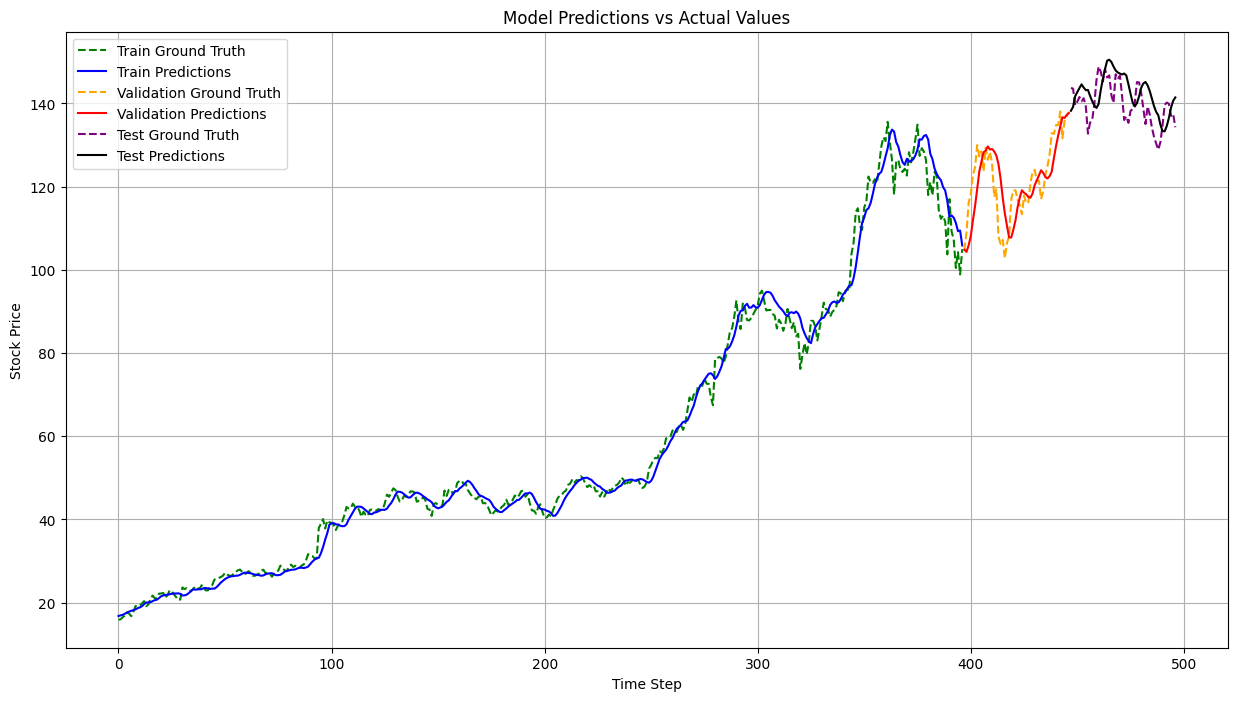

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Hyperparameters
input_len = 5   # Length of input sequences
output_len = 1  # Length of output sequence
batch_size = 8
epochs = 100
learning_rate = 0.001  # Lowered learning rate for stability

# 1. Load data
def load_data(csv_path):
    df = pd.read_csv(csv_path)  # Default is comma-separated
    df.columns = df.columns.str.strip()  # Strip any extra whitespace or hidden characters
    # print("Columns found:", df.columns.tolist())

    # Check for missing values
    if df["Close"].isnull().sum() > 0:
        print(f"Warning: There are {df['Close'].isnull().sum()} missing values in the 'Close' column.")
    
    prices = df["Close"].values.reshape(-1, 1)  # Get the 'Close' price column
    # Initialize the MinMaxScaler (normalized between 0 and 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit the scaler on the price data (normalize it)
    prices_scaled = scaler.fit_transform(prices)
    return prices_scaled, scaler

# 2. Create sequences for LSTM
def create_sequences(data, input_len, output_len):
    X, y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i + input_len])  # Input sequence
        y.append(data[i + input_len:i + input_len + output_len])  # Output sequence
    return np.array(X), np.array(y)

# 3. Define the LSTM Model using TensorFlow/Keras
def create_lstm_model(input_size=1, hidden_layer_size=128, output_size=1):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(hidden_layer_size, activation='relu', return_sequences=False, input_shape=(None, input_size)))
    model.add(tf.keras.layers.Dropout(0.2))  # Dropout for regularization
    model.add(tf.keras.layers.Dense(output_size))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# 4. Train the model with Early Stopping
def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), 
                        verbose=1, callbacks=[early_stopping])

    return model, history

# 5. Plot predictions vs ground truths (combined continuous with different colors)
def plot_predictions(train_preds, val_preds, test_preds, y_train, y_val, y_test):
    # Flatten the target values to match the prediction shapes
    y_train = y_train.flatten()
    y_val = y_val.flatten()
    y_test = y_test.flatten()

    # Ensure that predictions are correctly flattened
    train_preds = train_preds.flatten()
    val_preds = val_preds.flatten()
    test_preds = test_preds.flatten()

    # Plot combined predictions vs ground truths with different colors
    plt.figure(figsize=(15, 8))

    # Plot training data
    plt.plot(np.arange(len(y_train)), y_train, label="Train Ground Truth", linestyle='--', color='green')
    plt.plot(np.arange(len(train_preds)), train_preds, label="Train Predictions", linestyle='-', color='blue')

    # Plot validation data
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, 
             label="Validation Ground Truth", linestyle='--', color='orange')
    plt.plot(np.arange(len(train_preds), len(train_preds) + len(val_preds)), val_preds, 
             label="Validation Predictions", linestyle='-', color='red')

    # Plot test data
    plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), y_test, 
             label="Test Ground Truth", linestyle='--', color='purple')
    plt.plot(np.arange(len(train_preds) + len(val_preds), len(train_preds) + len(val_preds) + len(test_preds)), test_preds, 
             label="Test Predictions", linestyle='-', color='black')

    plt.legend()
    plt.title('Model Predictions vs Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Stock Price')
    plt.grid(True)
    plt.show()

# Main function
def main(csv_path):
    # Load and prepare data
    data, scaler = load_data(csv_path)
    
    # Create sequences for LSTM
    X, y = create_sequences(data, input_len, output_len)
    
    # Split into train, validation, and test sets (8:1:1 ratio)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
    
    # Reshape the data for LSTM: [samples, timesteps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Create the LSTM model
    model = create_lstm_model()

    # Train the model
    model, history = train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience=10)

    # Save the trained model to a keras file
    model.save('lstm_stock_model.keras')

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    print(f"Test Loss: {test_loss}")

    # Make predictions on the training, validation, and test sets
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_test)

    # Inverse transform the predictions and ground truth values
    train_preds = scaler.inverse_transform(train_preds)
    val_preds = scaler.inverse_transform(val_preds)
    test_preds = scaler.inverse_transform(test_preds)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot predictions vs ground truths
    plot_predictions(train_preds, val_preds, test_preds, y_train, y_val, y_test)

# Run the pipeline
if __name__ == "__main__":
    main("nvda_stock_data_2.csv")  # Replace with your file path